In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym

from table_maker import *
from functools import partial
from itertools import *
from math import ceil

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

From [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) q(x^\prime,t) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    q_t &= \frac{1 - q}{\alpha} - \beta q f(u - a) \\
    \epsilon a_t &= -a + \gamma f(u - a)
\end{align*}$$

In [30]:
# Values from Figure 2 ########################

# θ = .1
# α = 20
# β = .2
# ϵ = 5
# γ = .05
# μ = 1

θ = .1
α = 20
β = .4
ϵ = 5
γ = .1
μ = 1

###############################################

a, b = -100, 200
n = 10**3 * 2

###############################################
xs = np.linspace(a,b,n)
h = xs[1]-xs[0]

def firing_rate(u):
    return np.heaviside(u-θ, .5)
    
M = .5*np.exp( - np.abs( np.subtract.outer(xs, xs) ) ) * h

def convolution(u):
    return M@firing_rate(u)

def RK4_step(F, t, u, dt):
    k1 = F(t,u)
    k2 = F(t+dt/2, u + dt/2*k1)
    k3 = F(t+dt/2, u + dt/2*k2)
    k4 = F(t+dt, u + dt*k3)
    return u + dt/6*(k1+2*k2+2*k3+k4)

# u is a vector [u, q, a]
# F = lambda t, u: np.array([
#         1/μ * (-u[0] + M@(u[1]*firing_rate(u[0]) - u[2])),
#         (1-u[1])/α - β*u[1]*firing_rate(u[0]-u[2]),
#         (-u[2] + γ*firing_rate(u[0]-u[2]))/ϵ
#     ])
def F(t,u):
    temp = firing_rate(u[0] - u[2])
    ret = np.array([
        1/μ * (-u[0] + M@(u[1]*temp)),
        (1-u[1])/α - β*u[1]*temp,
        (-u[2] + γ*temp)/ϵ
    ])
    return ret

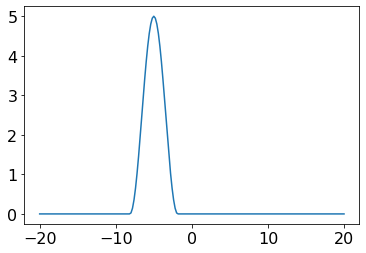

In [31]:
def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)
zs = np.linspace(-20,20,201)
plt.plot(zs, cos_bell(zs, center=-5, width=2*np.pi, height = 5))
plt.show()

In [37]:
# test 1
# u0 = np.zeros((3,n))
# u0[0] = cos_bell(xs, center=0, width=20)
# u0[1] += 1 # Set initial q to 1
# u0[2] = cos_bell(xs, center=-10, width=20)

# test 2
u0 = np.zeros((3,n))
u0[0] = cos_bell(xs, center=0, width=50)
u0[1] += 1 # Set initial q to 1

# test 3
# u0 = np.zeros((3,n))
# u0[0] = cos_bell(xs, center=0, width=50)
# u0[1] += 1 # Set initial q to 1


t0 = 0
t_final = 45
k = 1e-2

########################
steps = int(np.ceil( (t_final - t0)/k ))
k = (t_final - t0)/steps

us = [u0]
ts = [t0]

for step in range(steps):
    ts += [ts[-1] + k]
    us += [ RK4_step(F, ts[-1], us[-1], k) ]
    print('step %d/%d' % (step,steps), end='\r')

In [38]:
y_min = np.min(us)
y_max = np.max(us)
y_min -= .05*np.abs(y_max - y_min)
y_max += .05*np.abs(y_max - y_min)
window = y_min, y_max

stride = 20

fig, ax = plt.subplots(1, 1, figsize=(12,8))

line_u, = ax.plot(xs, us[0][0], 'b-', label="$u$")
line_q, = ax.plot(xs, us[0][1], 'g-', label="$q$")
line_a, = ax.plot(xs, us[0][2], 'm-', label="$a$")
ax.legend(loc='right')
ax.set_ylim(*window)
ax.set_xlim(0, b)
# ax.set_xlim(a,b)

def animate(i):
    print('step %d/%d' % (i,len(ts)), end='\r')
    line_u.set_ydata(us[i][0])
    line_q.set_ydata(us[i][1])
    line_a.set_ydata(us[i][2])
    return line_u,


# Init only required for blitting to give a clean slate.
def init():
    line_u.set_ydata(us[0])
    return line_u,

anim = animation.FuncAnimation(fig, animate, np.arange(0,len(ts),stride), init_func=init,
                              interval=1/24*1000, blit=True)

# anim.save('negative-feedback_pulse.mp4', writer='imagemagick', fps=24)

plt.close()
HTML(anim.to_html5_video())

In [34]:
1/(1+α*β) - γ

0.0111111111111111